<center><h1>Kaggle

In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error as mape # usage : print(mape(pred, observed))

import datetime

path = 'C:/Users/sebir/Desktop/M2 Toulouse/Défi IA/'

# Import data

In [2]:
# Training set, X
X = pd.read_csv(path + 'X_station_train.csv',
                parse_dates=['date'],
                infer_datetime_format=True)
X.columns = ['number_sta', 'date', 'wind_speed', 'temperature', 'dew_point_temperature', 'humidity', 'wind_direction', 'precipitation', 'Id']

# Training set, Y
Y = pd.read_csv(path + 'Y_train.csv',
                parse_dates=['date'],
                infer_datetime_format=True)

# Preprocess data

We have to group the data by data in order to have something comparable with `Y`

In [3]:
X['day'] = X['date'].apply(lambda x: x.date())

In [4]:
X_agg = X.copy()
X_agg = X_agg.groupby(by = ['day', 'number_sta'], as_index = False).agg({
    "number_sta"            : "first",
    "wind_speed"            : "median",
    "temperature"           : "median",
    "dew_point_temperature" : "median",
    "humidity"              : "median",
    "wind_direction"        : "median",
    "precipitation"         : "sum"
})

In [ ]:
X_agg.isna().sum()

In [ ]:
Y.isna().sum()

We firstly drop all the NAs.

In [5]:
X_agg.dropna(inplace = True)
Y = Y.loc[X_agg.index]

Y.dropna(inplace = True)
X_agg = X_agg.loc[Y.index]

Adding the month before deleting the date, since we have this information in `X_test`:

In [11]:
X_agg['month'] = X_agg['day'].apply(lambda x: x.month)

We then delete the Id in `Y` which won't be helpful

In [13]:
X_agg.drop(['day'], axis = 1, inplace = True)
Y.drop(['date', 'Id'], axis = 1, inplace = True)

# Trial with Random Forest

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_agg, Y['Ground_truth'], test_size = 0.3)

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [34]:
y_predict = rf.predict(X_test)
print(f"Score: {mape(y_predict, y_test)}")

Score: 1.2243040359696433


We can try to first perform a scaler before doing the data:

In [35]:
from sklearn.preprocessing import scale
X_scaled = scale(X_agg.drop('number_sta', axis = 1)) # centralisation et normalisation
X_scaled = pd.DataFrame(X_scaled, columns = X_agg.drop('number_sta', axis = 1).columns)
X_scaled['number_sta'] = X_agg['number_sta'].to_list()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y['Ground_truth'], test_size = 0.3)
rf_scaled = RandomForestRegressor(n_estimators = 200)
rf_scaled.fit(X_train, y_train)
y_predict = rf_scaled.predict(X_test)
print(f"Score: {mape(y_predict, y_test)}")

Score: 1.2104502225985723


We can try to fit and learn several times with different parameters to see if it gives better results. Things to try:
* whether scaling gives better result or not (perform a few ones for scaled and non-scaled data, then see distribution). We can also fit the models on the same scaled and non-scaled dataset, using `random_state = xx` of `train_test_split`, to compare.
* the importance of `n_estimators`

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale

from tqdm.notebook import trange

# Performing the scaling once
X_scaled = scale(X_agg.drop('number_sta', axis = 1)) # centralisation et normalisation
X_scaled = pd.DataFrame(X_scaled, columns = X_agg.drop('number_sta', axis = 1).columns)
X_scaled['number_sta'] = X_agg['number_sta'].to_list()


nbTrials = 15

# Without scaling
scores_without_scaling = []
for i in trange(nbTrials):
    X_train, X_test, y_train, y_test = train_test_split(X_agg, Y['Ground_truth'], test_size = 0.3)
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_predict = rf.predict(X_test)
    scores_without_scaling.append(mape(y_predict, y_test))

# With scaling
scores_with_scaling = []
for i in trange(nbTrials):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y['Ground_truth'], test_size = 0.3)
    rf_scaled = RandomForestRegressor()
    rf_scaled.fit(X_train, y_train)
    y_predict = rf_scaled.predict(X_test)
    scores_with_scaling.append(mape(y_predict, y_test))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
print("Without scaler:")
print(f"{(np.array(scores_without_scaling) < 10).sum()}/15 converged")
print(f"Mean of MAPE score = {np.array(scores_without_scaling)[np.array(scores_without_scaling) < 10].mean()}")

print("With scaler:")
print(f"{(np.array(scores_with_scaling) < 10).sum()}/15 converged")
print(f"Mean of MAPE score = {np.array(scores_with_scaling)[np.array(scores_with_scaling) < 10].mean()}")

# print("Mean with scaler:")
# np.array(scores_without_scaling)[np.array(scores_without_scaling) < 10].mean()

Without scaler:
6/15 converged
Mean of MAPE score = 1.2236087599158108
With scaler:
8/15 converged
Mean of MAPE score = 1.2322435844572048


In [64]:
from tqdm.notebook import tqdm

# Performing the scaling once
X_scaled = scale(X_agg.drop('number_sta', axis = 1)) # centralisation et normalisation
X_scaled = pd.DataFrame(X_scaled, columns = X_agg.drop('number_sta', axis = 1).columns)
X_scaled['number_sta'] = X_agg['number_sta'].to_list()


n_estimators = [100, 112, 125, 137, 150, 162, 175, 187, 200, 212, 225, 237, 250, 262, 275, 287, 300]

# With scaling
scores_estimators = []
for n_estimator in tqdm(n_estimators):
    print(f"With {n_estimator} trees:")
    mean = []
        
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y['Ground_truth'], test_size = 0.3)
    rf_scaled = RandomForestRegressor(n_estimators = n_estimator)
    rf_scaled.fit(X_train, y_train)
    y_predict = rf_scaled.predict(X_test)
    score = mape(y_predict, y_test)

    while score > 1000:
        print("Score was > 1000")
        # If diverged, run again until we get convergence
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y['Ground_truth'], test_size = 0.3)
        rf_scaled = RandomForestRegressor(n_estimators = n_estimator)
        rf_scaled.fit(X_train, y_train)
        y_predict = rf_scaled.predict(X_test)
        score = mape(y_predict, y_test)
            
    print("Converged")
    
    scores_estimators.append(score)

  0%|          | 0/17 [00:00<?, ?it/s]

With 100 trees:
Score was > 1000
Score was > 1000
Score was > 1000
Converged
With 112 trees:
Score was > 1000
Converged
With 125 trees:
Converged
With 137 trees:
Converged
With 150 trees:
Score was > 1000
Converged
With 162 trees:
Converged
With 175 trees:
Converged
With 187 trees:
Converged
With 200 trees:
Converged
With 212 trees:
Converged
With 225 trees:
Converged
With 237 trees:
Score was > 1000
Converged
With 250 trees:
Converged
With 262 trees:
Score was > 1000
Converged
With 275 trees:
Converged
With 287 trees:
Converged
With 300 trees:
Converged


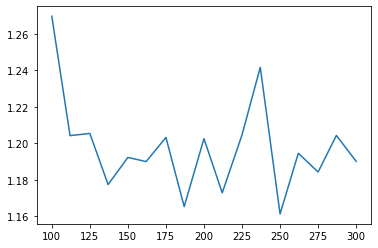

In [65]:
import matplotlib.pyplot as plt
plt.plot(n_estimators, scores_estimators)

# Trial with XGBRegressor

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_agg, Y['Ground_truth'], test_size = 0.3)
from sklearn.ensemble import GradientBoostingRegressor
rf = GradientBoostingRegressor()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
print(f"Score: {mape(y_predict, y_test)}")

# Fill in the gaps
We have to find a way to fill the gaps in the data. Suggested ways:
* fill the mean or the median, e.g., for a given variable
    * take the general median of the whole training dataset
    * take the median of the month
* take the value from the nearest neighbour
* interpolate the value from nearest neighbours

,number_sta,lat,lon,height_sta
0,86118001,46.477,0.985,120.0
1,86149001,46.917,0.025,60.0
2,56081003,48.050,-3.660,165.0
3,53215001,47.790,-0.710,63.0
4,22135001,48.550,-3.380,148.0
...,...,...,...,...
320,86137003,47.035,0.098,96.0
321,86165005,46.412,0.841,153.0
322,86273001,46.464,1.042,121.0
323,91200002,48.526,1.993,116.0


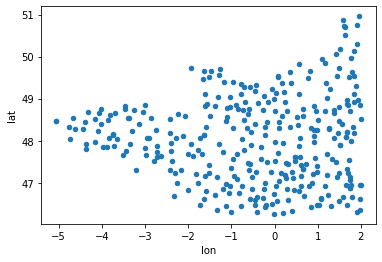

In [31]:
stations = pd.read_csv(path + 'stations_coordinates.csv')
display(stations)
stations.plot(x = 'lon', y = 'lat', kind = 'scatter');

# Submission

In [7]:
X_test = pd.read_csv(path + 'X_station_test.csv')
X_test

,dd,hu,td,t,ff,precip,month,Id
0,NaN,NaN,NaN,278.35,NaN,NaN,12,14047002_277_4
1,NaN,NaN,NaN,278.40,NaN,0.0,12,14047002_277_5
2,NaN,NaN,NaN,279.01,NaN,0.0,12,14047002_277_6
3,NaN,NaN,NaN,279.66,NaN,0.0,12,14047002_277_7
4,NaN,NaN,NaN,279.99,NaN,0.0,12,14047002_277_8
...,...,...,...,...,...,...,...,...
2304797,190.0,82.8,277.00,279.74,10.62,0.0,12,95690001_176_19
2304798,195.0,84.2,277.44,279.93,11.86,0.0,12,95690001_176_20
2304799,199.0,85.7,277.95,280.21,11.77,0.0,12,95690001_176_21
2304800,198.0,85.3,278.25,280.58,10.16,0.0,12,95690001_176_22
